In [2]:
from load_sim_data import *
from load_shp import *
from sim_eval_pkg import *

Updated on 2025-06-11


In [3]:
alpha = ['a','b','c','d','e','f']
regions = [
    (-130, -60, 15, 60, 'North America'),
    (-20, 45, 30, 75, 'Europe'),
    (-85, -30, -56, 15, 'South America'),
    (90, 150, 5, 50, 'East Asia/Southeast Asia'),
    (-20, 60, -40, 35, 'Africa'),
    (110, 180, -50, 10, 'Australia/Oceania')
]
df = pd.read_csv(station_df_JJA_path).dropna(subset=['lat', 'lon'])
df['lon_adj'] = df['lon'].apply(lambda x: x if x <= 180 else x - 360)

___

### Figure 6

___

In [9]:
def plot_station_improvement(metric='r2', title_suffix='2010-2019 JJA', size_factor=150):
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3)
    ax_summary = fig.add_subplot(gs[1, 1], projection=ccrs.Robinson())
    ax_summary.set_global()
    ax_summary.coastlines(linewidth=0.5)
    ax_summary.add_feature(cfeature.OCEAN, color='whitesmoke')
    ax_summary.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5)

    subplot_positions = [(0, 0), (0, 1), (0, 2), (2, 0), (2, 1), (2, 2)]
    total_valid, total_improved = 0, 0

    for i, (lon_min, lon_max, lat_min, lat_max, name) in enumerate(regions):
        row, col = subplot_positions[i]
        ax = fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree())
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.5)
        ax.add_feature(cfeature.OCEAN, color='whitesmoke')
        ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5)

        region_data = df[(df['lon_adj'] >= lon_min) & (df['lon_adj'] <= lon_max) &
                         (df['lat'] >= lat_min) & (df['lat'] <= lat_max)]

        valid_stations = region_data[pd.notnull(region_data['max_r2']) & (region_data['max_r2'] > 0)]
        region_valid = len(valid_stations)
        total_valid += region_valid

        if metric == 'r2':
            improved = valid_stations['r2_improved']
            temp = valid_stations['temp_r2_improved']
            rh = valid_stations['rh_r2_improved']
            not_improved = ~valid_stations['r2_improved']
        elif metric == 'rmse':
            improved = valid_stations['rmse_improved']
            temp = valid_stations['temp_rmse_improved']
            rh = valid_stations['rh_rmse_improved']
            not_improved = ~valid_stations['rmse_improved']
        else:  # both
            improved = valid_stations['everything_improved']
            temp = valid_stations['temp_both_improved']
            rh = valid_stations['rh_both_improved']
            not_improved = ~valid_stations['both_improved']

        region_improved = improved.sum()
        total_improved += region_improved

        both = valid_stations[improved & temp & rh]
        temp_only = valid_stations[temp & ~valid_stations.index.isin(both.index)]
        rh_only = valid_stations[rh & ~valid_stations.index.isin(both.index)]
        not_improved_stations = valid_stations[not_improved]

        for subset, color in zip([both, temp_only, rh_only, not_improved_stations],
                                 ['green', 'red', 'blue', 'yellow']):
            if not subset.empty:
                ax.scatter(subset['lon_adj'], subset['lat'],
                           s=50, marker='*' if color != 'yellow' else 'o',
                           facecolor=color, edgecolor='black', alpha=0.7, linewidth=0.8, zorder=100)

        improvement_ratio = (region_improved / region_valid * 100) if region_valid else 0
        stats_text = f'{region_valid} stations\n{improvement_ratio:.1f}% {metric.upper()} improved'

        ax.text(0.02, 0.02, stats_text, transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round'), fontsize=10)
        ax.set_title(f'{alpha[i]}. {name}', fontsize=14)
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle=':')
        gl.top_labels = False
        gl.right_labels = False

        ax_summary.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
                        [lat_min, lat_min, lat_max, lat_max, lat_min],
                        transform=ccrs.PlateCarree(), color='black', linewidth=1)
        ax_summary.text((lon_min + lon_max)/2, (lat_min + lat_max)/2, str(i+1),
                        transform=ccrs.PlateCarree(), fontsize=12,
                        horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='white', alpha=0.7))

    ax_summary.set_title(f'Global Overview - {title_suffix}', fontsize=16)
    global_ratio = (total_improved / total_valid * 100) if total_valid else 0
    global_stats = f'Total valid stations: {total_valid}\nTotal {metric.upper()} improved: {total_improved}\nGlobal improvement: {global_ratio:.1f}%'

    ax_summary.text(0.01, 0.02, global_stats, transform=ax_summary.transAxes,
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round'), fontsize=12)

    legend_elements = [
        plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='green', markersize=15,
                   markeredgecolor='black', label='Both Improved'),
        plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markersize=15,
                   markeredgecolor='black', label='Temp Improved'),
        plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='blue', markersize=15,
                   markeredgecolor='black', label='RH Improved'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=15,
                   markeredgecolor='black', label='Not Improved')
    ]

    legend_ax1 = fig.add_axes([0.26, 0.55, 0.15, 0.05])
    legend_ax1.axis('off')
    legend1 = legend_ax1.legend(handles=legend_elements, loc='center', title='Station Type', fontsize=12, title_fontsize=12,
                                 frameon=True, framealpha=0.9)

    plt.tight_layout()
    plt.subplots_adjust(top=0.94, hspace=0.15, wspace=0.3, bottom=0.08)
    plt.show()

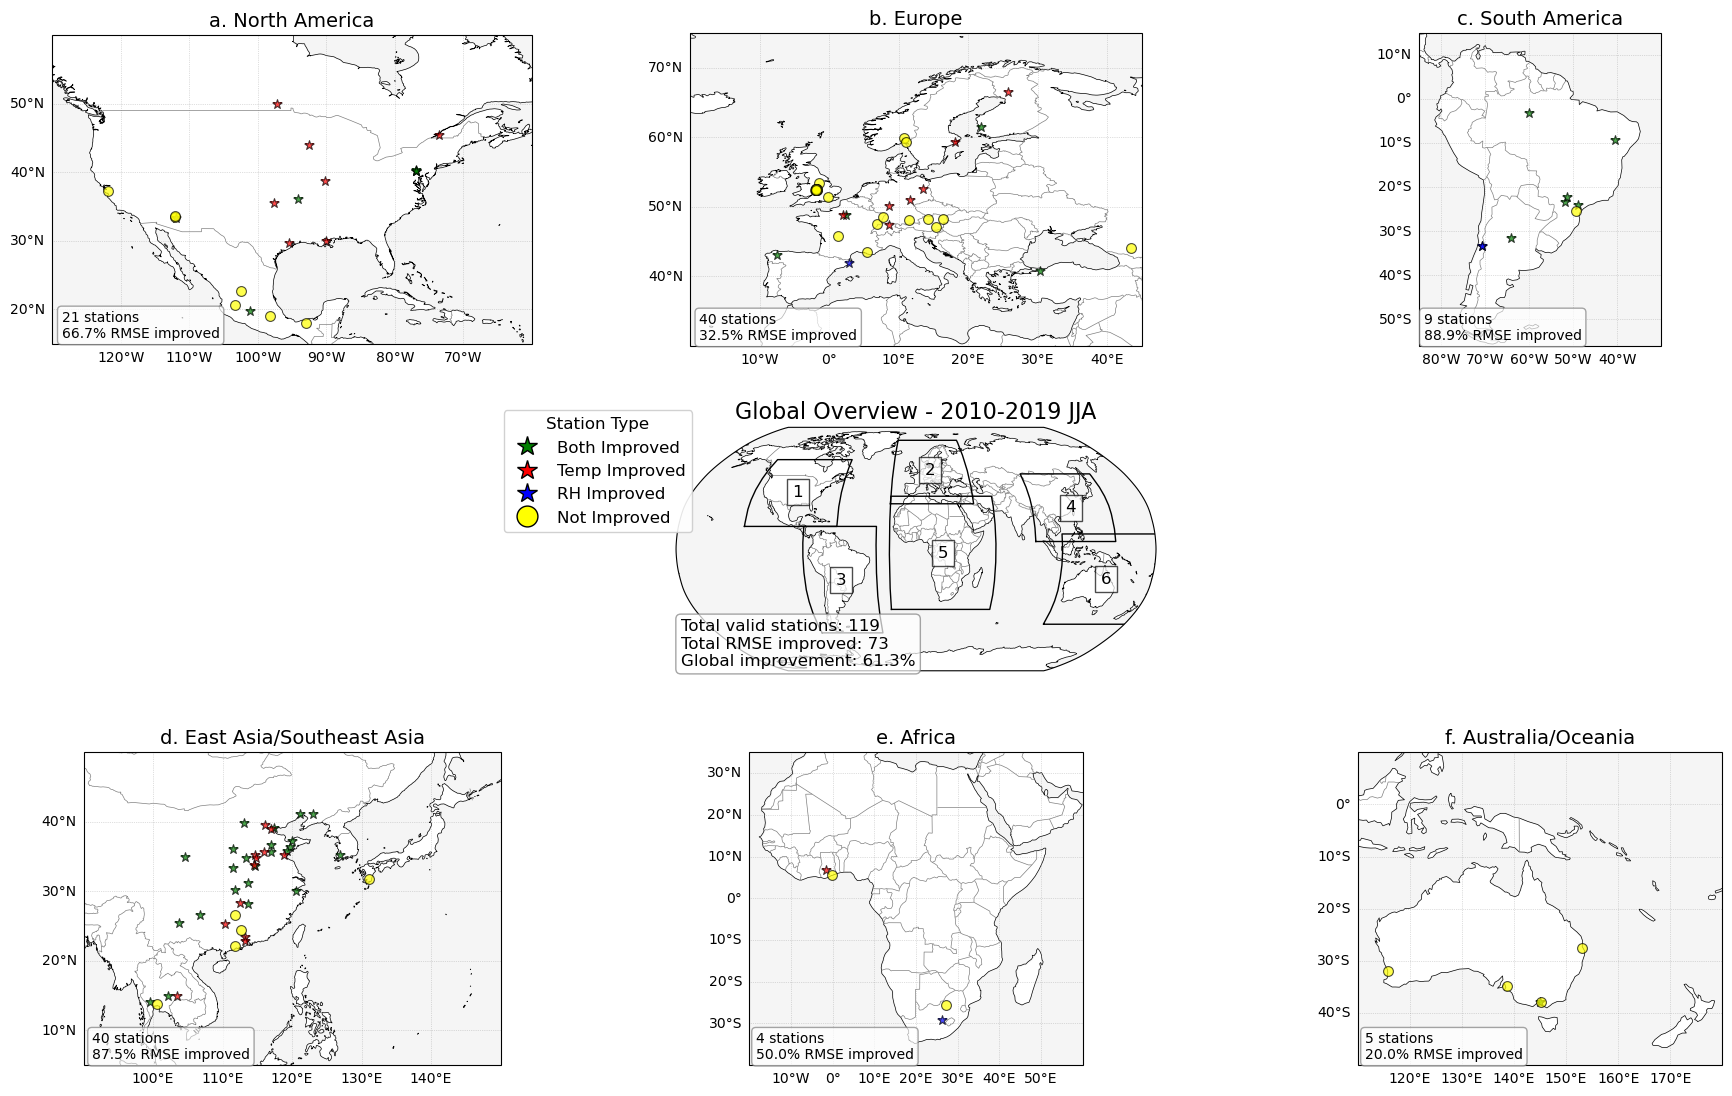

In [11]:
plot_station_improvement(metric='rmse', title_suffix='2010-2019 JJA', size_factor=150)